<a href="https://colab.research.google.com/github/zymrtask/Face-Mask-Detection-using-Mask-R-CNN/blob/master/Face_Mask_Detection_using_Mask_R_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [2]:
import numpy as np 
import pandas as pd 
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches
import os
import time

In [3]:
def generate_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

In [4]:
def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0

In [6]:
def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([image_id])
        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target

In [7]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [8]:
imgs = list(sorted(os.listdir("/content/drive/My Drive/Zymr_Task/images/")))

In [9]:
labels = list(sorted(os.listdir("/content/drive/My Drive/Zymr_Task/annotations/")))

In [11]:
class MaskDataset(object):
    def __init__(self, transforms):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir("/content/drive/My Drive/Zymr_Task/images/")))
        self.labels = list(sorted(os.listdir("/content/drive/My Drive/Zymr_Task/annotations/")))

    def __getitem__(self, idx):
        # load images ad masks
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join("/content/drive/My Drive/Zymr_Task/images/", file_image)
        label_path = os.path.join("/content/drive/My Drive/Zymr_Task/annotations/", file_label)
        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(idx, label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [13]:
data_transform = transforms.Compose([
        transforms.ToTensor(), 
    ])

In [14]:
data_transform

Compose(
    ToTensor()
)

In [15]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [16]:
dataset = MaskDataset(data_transform)
dataset

In [17]:
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=4, collate_fn=collate_fn)

In [19]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [20]:
model = get_model_instance_segmentation(3)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break    

[{'boxes': tensor([[ 79., 105., 109., 142.],
        [185., 100., 226., 144.],
        [325.,  90., 360., 141.]], device='cuda:0'), 'labels': tensor([0, 1, 0], device='cuda:0'), 'image_id': tensor([0], device='cuda:0')}, {'boxes': tensor([[321.,  34., 354.,  69.],
        [224.,  38., 261.,  73.],
        [299.,  58., 315.,  81.],
        [143.,  74., 174., 115.],
        [ 74.,  69.,  95.,  99.],
        [191.,  67., 221.,  93.],
        [ 21.,  73.,  44.,  93.],
        [369.,  70., 398.,  99.],
        [ 83.,  56., 111.,  89.]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0], device='cuda:0'), 'image_id': tensor([1], device='cuda:0')}, {'boxes': tensor([[ 68.,  42., 105.,  69.],
        [154.,  47., 178.,  74.],
        [238.,  34., 262.,  69.],
        [333.,  31., 366.,  65.]], device='cuda:0'), 'labels': tensor([1, 1, 1, 2], device='cuda:0'), 'image_id': tensor([2], device='cuda:0')}, {'boxes': tensor([[ 52.,  53.,  73.,  76.],
        [ 72.,  53.,  92.,  75.],
  

In [23]:
num_epochs = 20
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)


In [ ]:
len_dataloader = len(data_loader)
len_dataloader

In [26]:
start = time.time()
print("--------------------------------------------------------")
print("Starting training ...")
print("--------------------------------------------------------")

--------------------------------------------------------
Starting training ...
--------------------------------------------------------


In [27]:
for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
#         print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
        epoch_loss += losses
    print(epoch_loss)

/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


tensor(87.6294, device='cuda:0', grad_fn=<AddBackward0>)
tensor(61.9175, device='cuda:0', grad_fn=<AddBackward0>)
tensor(49.2783, device='cuda:0', grad_fn=<AddBackward0>)
tensor(42.4220, device='cuda:0', grad_fn=<AddBackward0>)
tensor(37.7272, device='cuda:0', grad_fn=<AddBackward0>)
tensor(39.8869, device='cuda:0', grad_fn=<AddBackward0>)
tensor(33.4196, device='cuda:0', grad_fn=<AddBackward0>)
tensor(28.9805, device='cuda:0', grad_fn=<AddBackward0>)
tensor(28.5217, device='cuda:0', grad_fn=<AddBackward0>)
tensor(27.7997, device='cuda:0', grad_fn=<AddBackward0>)
tensor(28.0721, device='cuda:0', grad_fn=<AddBackward0>)
tensor(24.6539, device='cuda:0', grad_fn=<AddBackward0>)
tensor(27.2037, device='cuda:0', grad_fn=<AddBackward0>)
tensor(26.3702, device='cuda:0', grad_fn=<AddBackward0>)
tensor(24.5804, device='cuda:0', grad_fn=<AddBackward0>)
tensor(23.7260, device='cuda:0', grad_fn=<AddBackward0>)
tensor(25.1639, device='cuda:0', grad_fn=<AddBackward0>)
tensor(23.2385, device='cuda:0'

In [40]:
end = time.time()
print("--------------------------------------------------------")
print("Training complete in ", end - start, " seconds")
print("--------------------------------------------------------")

--------------------------------------------------------
Training complete in  519.2514946460724  seconds
--------------------------------------------------------


In [29]:
for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break

In [30]:
print("Prediction Start Time")
start = time.time()
print("--------------------------------------------------------")
print("Starting testing ...")
print("--------------------------------------------------------")

Prediction Start Time
--------------------------------------------------------
Starting testing ...
--------------------------------------------------------


In [31]:
model.eval()
preds = model(imgs)
preds

[{'boxes': tensor([[184.0740, 100.5778, 224.3312, 143.9483]], device='cuda:0',
         grad_fn=<StackBackward>),
  'labels': tensor([1], device='cuda:0'),
  'scores': tensor([0.9950], device='cuda:0', grad_fn=<IndexBackward>)},
 {'boxes': tensor([[319.5764,  33.0409, 351.2986,  70.0080],
          [225.0889,  36.5585, 258.5464,  73.8790],
          [ 19.9426,  72.2380,  41.6659,  92.4071],
          [143.4611,  75.1135, 172.3589, 111.9491],
          [192.3033,  66.0888, 215.5599,  92.5831],
          [298.1561,  58.2269, 312.8155,  80.4227],
          [ 80.4792,  56.4514, 112.8210,  87.2608],
          [142.9204,  72.0645, 172.1380, 110.1055],
          [ 80.8109,  55.4200, 111.9932,  87.2119]], device='cuda:0',
         grad_fn=<StackBackward>),
  'labels': tensor([1, 1, 1, 1, 1, 1, 2, 2, 1], device='cuda:0'),
  'scores': tensor([0.9949, 0.9927, 0.9818, 0.9697, 0.9587, 0.9408, 0.6619, 0.3287, 0.2769],
         device='cuda:0', grad_fn=<IndexBackward>)},
 {'boxes': tensor([[ 71.8398,

In [32]:
end = time.time()
print("--------------------------------------------------------")
print("Training complete in ", end - start, " seconds")
print("--------------------------------------------------------")

--------------------------------------------------------
Training complete in  1.650587797164917  seconds
--------------------------------------------------------


In [33]:
def plot_image(img_tensor, annotation):
    
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data

    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    
    for box in annotation["boxes"]:
        xmin, ymin, xmax, ymax = box

        # Create a Rectangle patch
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

Prediction


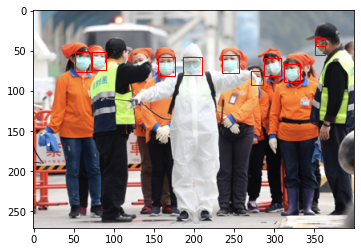

Target


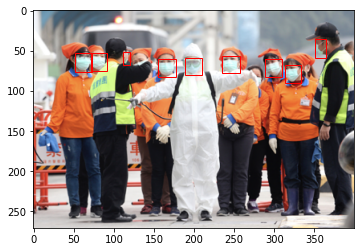

In [34]:
print("Prediction")
plot_image(imgs[3], preds[3])
print("Target")
plot_image(imgs[3], annotations[3])

In [35]:
torch.save(model.state_dict(),'model.pt')

In [36]:
model2 = get_model_instance_segmentation(3)

In [37]:
model2.load_state_dict(torch.load('model.pt'))
model2.eval()
model2.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [38]:
pred2 = model2(imgs)

In [39]:
print("Predict with loaded model")
plot_image(imgs[4], pred2[4])

Predict with loaded model


IndexError: ignored